# Problem Set 3

This is the third, and also the last, homework assignment, which accounts for $15\%$ of your final grade. 

There are three questions, and their weights are:
* Q1: $40\%$,
* Q2: $30\%$,
* Q3: $30\%$.

You may work with other students. The maximal number of students per group is two. However, you can work on your own. Be sure to indicate with whom you have worked in your submission.

### Deadline: Dec 1, 2023 (5 PM HK Time). 

There is a penalty for late submissions: $5\%$ will be subtracted from the total mark for every additional day after the deadline. 

You need to download the data using the following Dropbox link: https://www.dropbox.com/scl/fi/w7ijrh70sivrk4kgz4qb2/ps3_data.zip?rlkey=0euuf6s2sz17xem1qxza1rfxa&dl=0.

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(6, 4))
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 15
np.set_printoptions(precision=4, suppress=True)
from dateutil.parser import parse
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Q1. Testing Fama-French Three Factor Models

In week 10, we introduced how to use the ```statmodels``` package to test the Capital Asset Pricing Model (CAPM). In this question, we further explore two other factors, the size (SMB) and value (HML) factors. In fact, the Fama-French three-factor (MKT, SMB, HML) model has been one of the most popular factor pricing models in the past 30 years. In this question, you will explore whether the three-factor model is able to explain portfolio returns. 

The baseline model is that the required return of an asset should be determined by the systematic risks (betas) as follows: <br>
<br>
$$
\mathbf{E} [ R_i ] - R_f = \beta^{mkt}_i \big( \mathbf{E} [ R_m ] - R_f \big) + \beta^{smb}_i \big( \mathbf{E} [ R_{smb} ] - R_f \big) + \beta^{hml}_i \big( \mathbf{E} [ R_{hml} ] - R_f \big), 
$$
 * $\mathbf{E} [ R_i ]$: the expected/required return of the asset $i$
 * $R_f$: the risk-free rate
 * $\mathbf{E} [ R_m ]$: the expected/required return of the market portfolio ($m$ is the abbreviation for market)
 * $\mathbf{E} [ R_{smb} ]$: the expected/required return of the SMB portfolio
 * $\mathbf{E} [ R_{hml} ]$: the expected/required return of the HML portfolio
 * $\beta^{mkt}_i$, $\beta^{smb}_i$, and $\beta^{hml}_i$: the beta, or the sensitivity of the expected excess return to the expected excess market, SMB, and HML returns

We estimate the above model via the simple OLS regression:   <br>
<br>
$$
R_{it} - R_{ft} = \alpha_i + \beta^{mkt}_i \big( R_{mt} - R_{ft} \big) + \beta^{smb}_i \big( R_{smb,t} - R_{ft} \big) + \beta^{hml}_i \big( R_{hml,t} - R_{ft} \big) + \epsilon_{it}, 
$$
 * $R_{it}$, $R_{mt}$, $R_{smb,t}$, $R_{hml,t}$, and $R_{ft}$: the time-$t$ return of asset $i$, the market portfolio, the SMB portfolio, the HML portfolio, and the risk-free asset
 * $\epsilon_{it}$: the random error term
 * $\alpha_i$ is called the pricing errors (or just the alpha)

### Q1.1

First, you need to load the data in ```week10_test_assets.xlsx```, with three sheets:
- ```25portfolios_size_value```: 25 portfolios sorted by firm size and value signals
- ```25portfolios_size_mom```: 25 portfolios sorted by firm size and momentum signals
- ```FF3_factors```: Fama-French three factors

Second, you need to compute the **monthly excess returns** of the above three datasets, following what we did in the lecture 10. 

In [2]:
test_assets_daily = pd.read_excel("../data_to_share/week10_test_assets.xlsx", sheet_name="25portfolios_size_value",
                                 index_col=0)
test_assets_daily.index = [str(x) for x in test_assets_daily.index]
test_assets_daily.index = [parse(x) for x in test_assets_daily.index]
#test_assets_daily.head()

test_assets_daily2 = pd.read_excel("../data_to_share/week10_test_assets.xlsx", sheet_name="25portfolios_size_mom",
                                   index_col=0)
test_assets_daily2.index = [str(x) for x in test_assets_daily2.index]
test_assets_daily2.index = [parse(x) for x in test_assets_daily2.index]

factors_daily = pd.read_excel("../data_to_share/week10_test_assets.xlsx", sheet_name="FF3_factors", index_col=0)
factors_daily.index = [str(x) for x in factors_daily.index]
factors_daily.index = [parse(x) for x in factors_daily.index]
#factors_daily.head()

In [3]:
FF3_daily = factors_daily[['Mkt-RF', 'SMB', 'HML']]/100
RF_daily = factors_daily[['RF']]/100
FF3_gross_daily = pd.DataFrame(FF3_daily.values + RF_daily.values @ np.ones((1,3)), 
                               columns=["MKT", 'SMB_gross', 'HML_gross'])
FF3_gross_daily.index = FF3_daily.index
test_assets_daily = test_assets_daily/100
test_assets_daily2 = test_assets_daily2/100

In [4]:
FF3_gross_monthly = (1+FF3_gross_daily).resample('M').prod() - 1
RF_monthly = (1+RF_daily).resample('M').prod() - 1

FF3_monthly = pd.DataFrame(FF3_gross_monthly.values - RF_monthly.values @ np.ones((1,3)), 
                           index=FF3_gross_monthly.index, 
                           columns=['MKT_RF', 'SMB', 'HML'])

In [5]:
test_assets_monthly = (1+test_assets_daily).resample('M').prod() - 1
Tm, N = test_assets_monthly.shape
test_assets_RF_monthly = pd.DataFrame(test_assets_monthly.values - RF_monthly.values @ np.ones((1,N)), 
                                      index=test_assets_monthly.index, columns=test_assets_monthly.columns)

test_assets_monthly2 = (1+test_assets_daily2).resample('M').prod() - 1
Tm_2, N_2 = test_assets_monthly2.shape
test_assets_RF_monthly2 = pd.DataFrame(test_assets_monthly2.values - RF_monthly.values @ np.ones((1,N_2)), 
                                       index=test_assets_monthly2.index, columns=test_assets_monthly2.columns)


### Q1.2

In this question, you are required to run the OLS regressions for the cross-section of **25 portfolios sorted by firm size and value signals**. You need to estimate the following
- ```alpha``` ($\alpha_i$ in the above question): an ```np.array``` with ```alpha.shape=(25,1)```
- ```beta``` ($\beta_i^{mkt}$, $\beta_i^{smb}$, $\beta_i^{hml}$): an ```np.array``` with ```beta.shape=(25,3)```
- The $95\%$ confidence intervals of ```alpha``` and ```beta```. 

After you estimate the above parameters, you need to create a $2 \times 2$ bar plots, where the x-axis is always the portfolio names. 
```python
fig, axes = plt.subplots(2, 2, figsize=(16,8), sharex=True)
```
- ```axes[0,0]```: the y-axis plots ```alpha``` and its $95\%$ confidence intervals (as in our lecture note)
- ```axes[0,1]```: the y-axis plots ```beta[:,0]``` (market betas) and its $95\%$ confidence intervals 
- ```axes[1,0]```: the y-axis plots ```beta[:,1]``` (SMB betas) and its $95\%$ confidence intervals 
- ```axes[1,1]```: the y-axis plots ```beta[:,2]``` (HML betas) and its $95\%$ confidence intervals 

In [6]:
results_list = []
alpha = np.zeros((N,))
alpha_95CI = np.zeros((2, N))
beta = np.zeros((N,3))
beta_95CI = np.zeros((3, 2, N))

for n in range(N):
    model = sm.OLS(test_assets_RF_monthly.values[:,n], sm.add_constant(FF3_monthly.values))
    results = model.fit()
    results_list.append(results)
    alpha[n] = results.params[0]
    beta[n,:] = results.params[1:4]
    alpha_95CI[:,n] = results.conf_int(alpha=0.05)[0,:]
    beta_95CI[:,:,n] = results.conf_int(alpha=0.05)[1:,:]


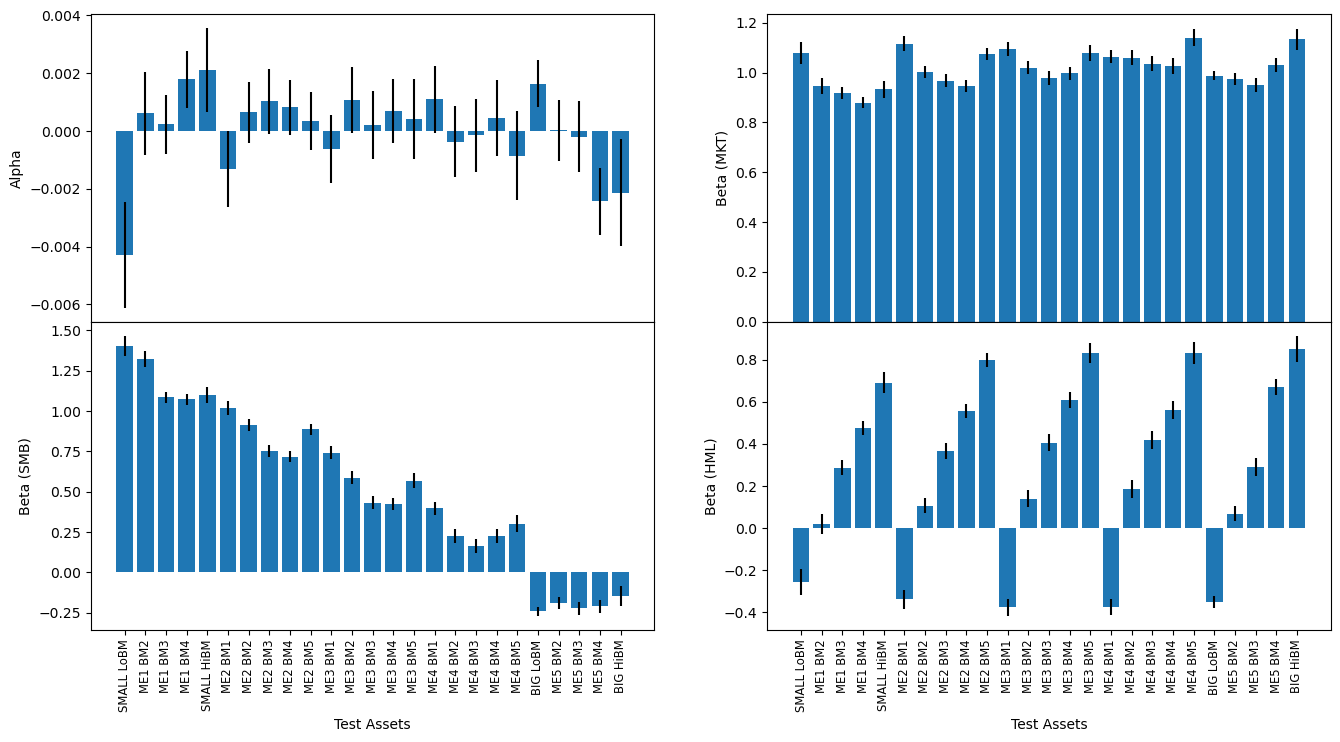

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16,8), sharex=True)

axes[0,0].bar(np.arange(1,26,1), alpha, yerr=(alpha-alpha_95CI)[0,:])
axes[0,0].set_xticks(np.arange(1,26,1))
axes[0,0].set_xticklabels(test_assets_monthly.columns, rotation=90, fontsize='small')
#axes[0].set_xlabel('Test Assets')
axes[0,0].set_ylabel('Alpha')

axes[0,1].bar(np.arange(1,26,1), beta[:,0], yerr=(beta[:,0]-beta_95CI[0,:])[0,:])
axes[0,1].set_xticks(np.arange(1,26,1))
axes[0,1].set_xticklabels(test_assets_monthly.columns, rotation=90, fontsize='small')
#axes[0,1].set_xlabel('Test Assets')
axes[0,1].set_ylabel('Beta (MKT)')

axes[1,0].bar(np.arange(1,26,1), beta[:,1], yerr=(beta[:,1]-beta_95CI[1,:])[0,:])
axes[1,0].set_xticks(np.arange(1,26,1))
axes[1,0].set_xticklabels(test_assets_monthly.columns, rotation=90, fontsize='small')
axes[1,0].set_xlabel('Test Assets')
axes[1,0].set_ylabel('Beta (SMB)')

axes[1,1].bar(np.arange(1,26,1), beta[:,2], yerr=(beta[:,2]-beta_95CI[2,:])[0,:])
axes[1,1].set_xticks(np.arange(1,26,1))
axes[1,1].set_xticklabels(test_assets_monthly.columns, rotation=90, fontsize='small')
axes[1,1].set_xlabel('Test Assets')
axes[1,1].set_ylabel('Beta (HML)')

plt.subplots_adjust(wspace=0.2, hspace=0.0)

### Q1.3

Given the estimated betas (```beta```) in Q1.2, we can now explore whether the betas of MKT, SMB, and HML ($\beta_i^{mkt}$, $\beta_i^{smb}$, $\beta_i^{hml}$) help explain the cross-section of average returns of 25 portfolios sorted by firm size and value signals. In this question, you need to create scatter plots, where the y-axis always plots the realised average returns of 25 portfolios. Run the following codes:
```python
fig, axes = plt.subplots(2, 2, figsize=(8,8), sharey=True)
```

Four subplots are
- ```axes[0,0]```: the x-axis is the predicted average returns implied by the Fama-French three-factor model
- ```axes[0,1]```: the x-axis is the market beta
- ```axes[1,0]```: the x-axis is the SMB beta
- ```axes[1,1]```: the x-axis is the HML beta

You need to compare this figure with the one plotted in the lecture note (Section 10.2.2). From these figures, whether the CAPM or the FF3 model has a better performance? Do SMB and HML help improve the explanatory power of the factor model, and how? 

In [8]:
mean_rets_ff3 = (FF3_monthly.values @ beta.T).mean(axis=0)
mean_rets_realized = test_assets_RF_monthly.values.mean(axis=0)

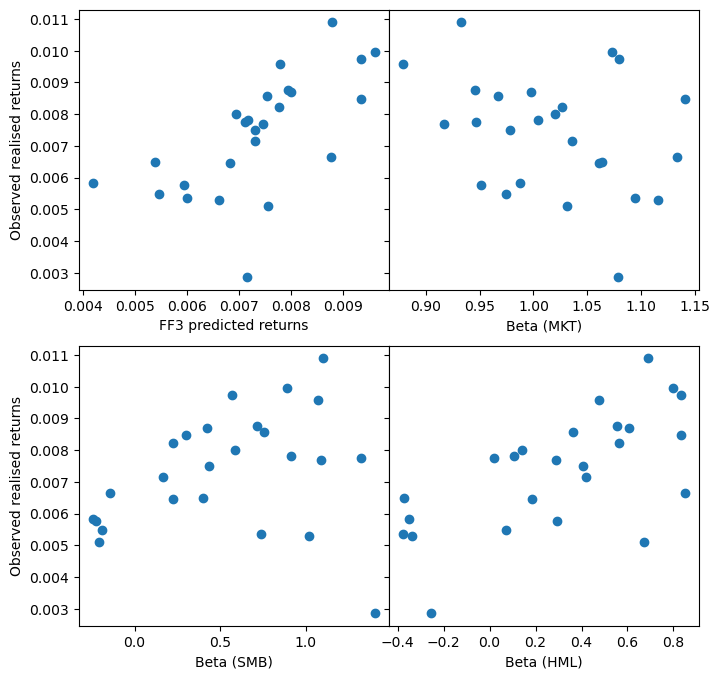

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(8,8), sharey=True)

axes[0,0].scatter(mean_rets_ff3, mean_rets_realized)
axes[0,0].set_xlabel('FF3 predicted returns')
axes[0,0].set_ylabel('Observed realised returns')

axes[0,1].scatter(beta[:,0], mean_rets_realized)
axes[0,1].set_xlabel('Beta (MKT)')
#axes[0,1].set_ylabel('Observed realised returns')

axes[1,0].scatter(beta[:,1], mean_rets_realized)
axes[1,0].set_xlabel('Beta (SMB)')
axes[1,0].set_ylabel('Observed realised returns')

axes[1,1].scatter(beta[:,2], mean_rets_realized)
axes[1,1].set_xlabel('Beta (HML)')
#axes[1,1].set_ylabel('Observed realised returns')

plt.subplots_adjust(wspace=0.0, hspace=0.2)

### Q1.4 

Repeat the analysis in Q1.2 and Q1.3 for another cross-section of 25 portfolios sorted by **firm size and momentum signal**. Do you detect some different observations between these two cross-sections? 

In [10]:
results_list = []
alpha = np.zeros((N,))
alpha_95CI = np.zeros((2, N))
beta = np.zeros((N,3))
beta_95CI = np.zeros((3, 2, N))

for n in range(N):
    model = sm.OLS(test_assets_RF_monthly2.values[:,n], sm.add_constant(FF3_monthly.values))
    results = model.fit()
    results_list.append(results)
    alpha[n] = results.params[0]
    beta[n,:] = results.params[1:4]
    alpha_95CI[:,n] = results.conf_int(alpha=0.05)[0,:]
    beta_95CI[:,:,n] = results.conf_int(alpha=0.05)[1:,:]

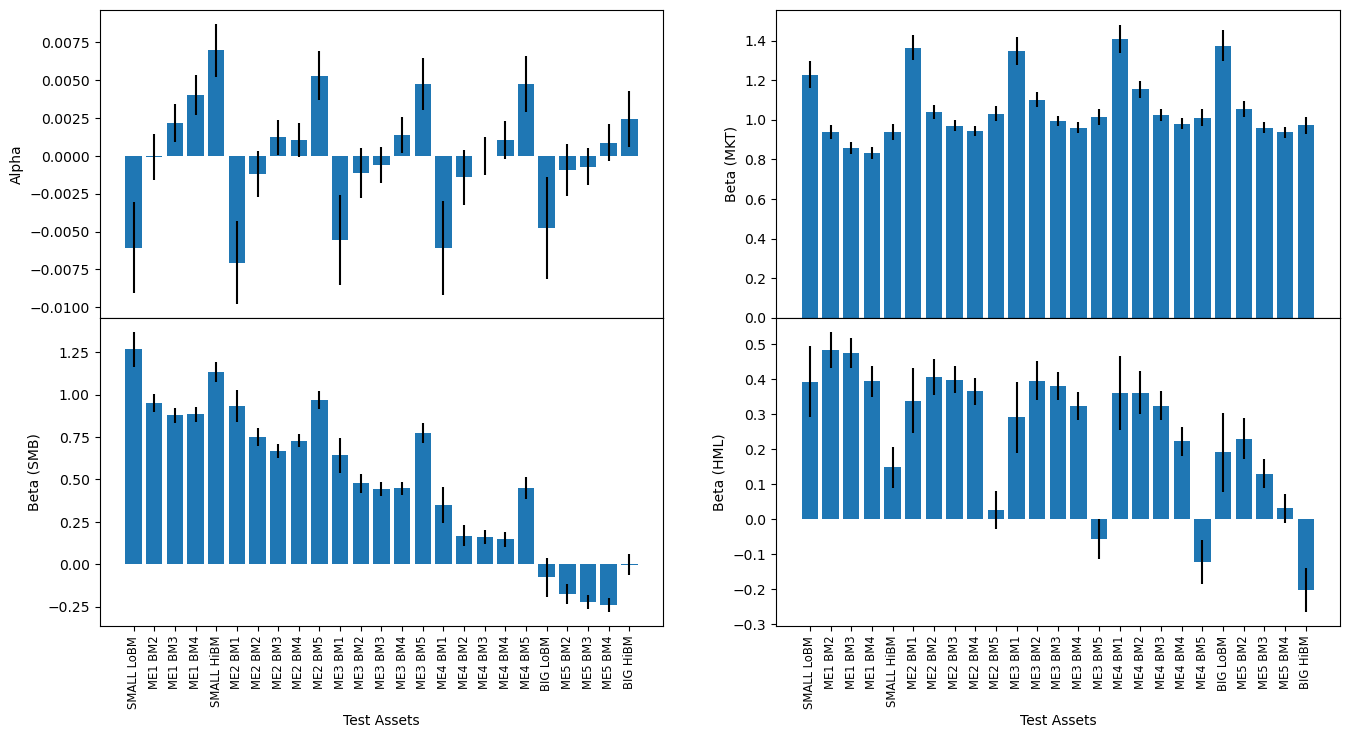

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16,8), sharex=True)

#alpha_err = alpha_95CI - alpha
#alpha_err[0,:] = - alpha_err[0,:]
axes[0,0].bar(np.arange(1,26,1), alpha, yerr=(alpha-alpha_95CI)[0,:])
axes[0,0].set_xticks(np.arange(1,26,1))
axes[0,0].set_xticklabels(test_assets_monthly.columns, rotation=90, fontsize='small')
#axes[0].set_xlabel('Test Assets')
axes[0,0].set_ylabel('Alpha')

#beta_err = beta[:,0]-beta_95CI[0,:]
#beta_err[0,:] = - beta_err[0,:]
axes[0,1].bar(np.arange(1,26,1), beta[:,0], yerr=(beta[:,0]-beta_95CI[0,:])[0,:])
axes[0,1].set_xticks(np.arange(1,26,1))
axes[0,1].set_xticklabels(test_assets_monthly.columns, rotation=90, fontsize='small')
#axes[0,1].set_xlabel('Test Assets')
axes[0,1].set_ylabel('Beta (MKT)')

axes[1,0].bar(np.arange(1,26,1), beta[:,1], yerr=(beta[:,1]-beta_95CI[1,:])[0,:])
axes[1,0].set_xticks(np.arange(1,26,1))
axes[1,0].set_xticklabels(test_assets_monthly.columns, rotation=90, fontsize='small')
axes[1,0].set_xlabel('Test Assets')
axes[1,0].set_ylabel('Beta (SMB)')

axes[1,1].bar(np.arange(1,26,1), beta[:,2], yerr=(beta[:,2]-beta_95CI[2,:])[0,:])
axes[1,1].set_xticks(np.arange(1,26,1))
axes[1,1].set_xticklabels(test_assets_monthly.columns, rotation=90, fontsize='small')
axes[1,1].set_xlabel('Test Assets')
axes[1,1].set_ylabel('Beta (HML)')

plt.subplots_adjust(wspace=0.2, hspace=0.0)

In [12]:
mean_rets_ff3 = (FF3_monthly.values @ beta.T).mean(axis=0)
mean_rets_realized = test_assets_RF_monthly2.values.mean(axis=0)

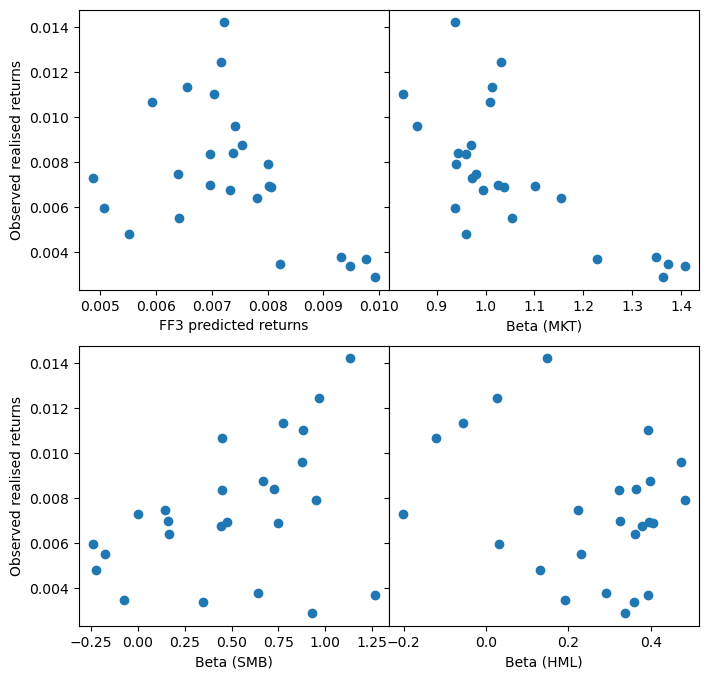

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(8,8), sharey=True)

axes[0,0].scatter(mean_rets_ff3, mean_rets_realized)
axes[0,0].set_xlabel('FF3 predicted returns')
axes[0,0].set_ylabel('Observed realised returns')

axes[0,1].scatter(beta[:,0], mean_rets_realized)
axes[0,1].set_xlabel('Beta (MKT)')
#axes[0,1].set_ylabel('Observed realised returns')

axes[1,0].scatter(beta[:,1], mean_rets_realized)
axes[1,0].set_xlabel('Beta (SMB)')
axes[1,0].set_ylabel('Observed realised returns')

axes[1,1].scatter(beta[:,2], mean_rets_realized)
axes[1,1].set_xlabel('Beta (HML)')
#axes[1,1].set_ylabel('Observed realised returns')

plt.subplots_adjust(wspace=0.0, hspace=0.2)

---

## Q2. Predicting Stock Returns

In this question, we focus on the cross-sectional predictability. We will run the OLS regressions to estimate the following models: <br>
<br>
$$
R_{i,t+1} = c + X^\top_{it} \beta + \epsilon_{i,t+1}, 
$$
* $R_{i,t+1}$: return of stock $i$ at time $t+1$
* $X_{it}$: the $K \times 1$ vector of signals of stock $i$ at time $t$ (i.e., we are living at time $t$ and observe $X_{it}$. We aim to predict the next-period $R_{i,t+1}$)
* The key parameter is $\beta$ : if $\beta_k$ ($1 \leq k \leq K$) is significantly different from zero, we can say that the $k$-th signal can predict stock returns. 

---

### Q2.1 

You need to load the panel data of US stocks (```GlobalFactors_USA_ps3.parquet```) and preprocess the data. The variables can be grouped into three categories as follows:
```python
identifier_var_list = ["id", "eom", "size_grp", "ret_exc_lead1m", "me"]

value_list = ['at_me', 'be_me', 'bev_mev', 'chcsho_12m', 'debt_me', 'div12m_me', 'ebitda_mev', 'eq_dur',
              'eqnetis_at', 'eqnpo_12m', 'eqnpo_me', 'eqpo_me', 'fcf_me', 'ival_me', 'netis_at', 'ni_me',
              'ocf_me', 'sale_me']

momentum_list = ['prc_highprc_252d', 'resff3_6_1', 'resff3_12_1', 'ret_3_1', 'ret_6_1', 'ret_9_1', 
                 'ret_12_1', 'seas_1_1na']
```

First, you need remove the firms that do not have enough historic observations available (remove those with less than 24 months observations). 

Second, if a firm's market capitalization (the column ```"me"```) is less than 0.001% of the total market capitalization of the whole US stock market **per period**, we will exclude this firm from our analysis **in this period**. 

In [14]:
identifier_var_list = ["id", "eom", "size_grp", "ret_exc_lead1m", "me"]

value_list = ['at_me', 'be_me', 'bev_mev', 'chcsho_12m', 'debt_me', 'div12m_me', 'ebitda_mev', 'eq_dur',
              'eqnetis_at', 'eqnpo_12m', 'eqnpo_me', 'eqpo_me', 'fcf_me', 'ival_me', 'netis_at', 'ni_me',
              'ocf_me', 'sale_me']

momentum_list = ['prc_highprc_252d', 'resff3_6_1', 'resff3_12_1', 'ret_3_1', 'ret_6_1', 'ret_9_1', 
                 'ret_12_1', 'seas_1_1na']

In [15]:
D = pd.read_parquet('../data_to_share/GlobalFactors_USA_ps3.parquet', engine='pyarrow')
D = D.set_index(['id', 'eom'])  # create a hierarchical index using two columns 'id' and 'eom' as the index. 
print(D.shape)

(2917805, 29)


In [16]:
history_lengths = D.index.to_frame()['id'].groupby(level=0).count()
cs_idx_with_history = history_lengths[history_lengths >= 24].index 
ts_idx = D.index.get_level_values(1).unique()
df_idx = pd.MultiIndex.from_product((ts_idx, cs_idx_with_history)).to_frame()[[]]

# left merge to produce a balanced panel
D_full = pd.merge(D, df_idx, how='inner', left_index=True, right_index=True)

In [17]:
D_full.head()

size_grp  ret_exc_lead1m         me     at_me     be_me  \
id      eom                                                                  
16417.0 2002-01-31    micro        0.003421  48.407500  2.189913  1.096187   
        2002-02-28    micro        0.002894  48.407500  2.184059  1.093257   
        2002-03-31    micro        0.169963  45.518220  1.976607  0.989414   
        2002-04-30    micro       -0.128442  53.325000  1.909435  0.947458   
        2002-05-31    micro        0.061289  46.339422  2.261668  1.122235   

                     bev_mev  chcsho_12m  debt_me  div12m_me  ebitda_mev  ...  \
id      eom                                                               ...   
16417.0 2002-01-31  1.109152   -0.009996      0.0   0.018919    0.053625  ...   
        2002-02-28  1.105046   -0.009996      0.0   0.018871    0.053427  ...   
        2002-03-31  0.964798   -0.073012      0.0   0.020069    0.046646  ...   
        2002-04-30  0.906528   -0.073012      0.0   0.017131    0.031954  ...   
        2002-05-31  1.096515   -0.073012      0.0   0.019351    0.038651  ...   

                      ocf_me   sale_me  prc_highprc_252d  resff3_6_1  \
id      eom                                                            
16417.0 2002-01-31  0.039092  0.437347               NaN   -0.051031   
        2002-02-28  0.038987  0.436178               NaN   -0.299929   
        2002-03-31  0.035284  0.394748               NaN    0.051677   
        2002-04-30  0.051387  0.349036               NaN   -0.157543   
        2002-05-31  0.060866  0.413423               NaN   -0.011454   

                    resff3_12_1   ret_3_1   ret_6_1   ret_9_1  ret_12_1  \
id      eom                                                               
16417.0 2002-01-31     0.154985  0.136413 -0.071260 -0.099492  0.011726   
        2002-02-28     0.010412 -0.089741 -0.123932 -0.112135 -0.020544   
        2002-03-31     0.044783 -0.028441  0.150601 -0.097864  0.029461   
        2002-04-30    -0.269798  0.008961  0.108768 -0.093853 -0.121399   
        2002-05-31     0.041506  0.176471  0.075933  0.035519  0.049463   

                    seas_1_1na  
id      eom                     
16417.0 2002-01-31    0.004526  
        2002-02-28    0.008963  
        2002-03-31   -0.006713  
        2002-04-30    0.010627  
        2002-05-31    0.000098  

[5 rows x 29 columns]

In [18]:
total_market_cap = D_full['me'].groupby(level=1).sum()
market_cap_filter = (D_full['me'] / total_market_cap) > 0.00001
D_full = D_full[market_cap_filter]

### Q2.2

Based on the preprocess data in Q2.1, you now need to perform the rank-transformation of the firm characteristics, as what we did in the lecture note. 

You need to rank and center each characteristic cross-sectionally to lie within the $[-0.5, 0.5]$ range.
  * In each month, you rank the stocks by their firm characteristic $k$ and divide their ranks by the number of stocks during this period. Finally, you need to substract it by 0.5. Hence, the rank-transformed firm characteristic $k$ is
  $$
  X_{ikt} = \frac{\text{rank}_{ikt}}{N_t} - 0.5
  $$
    * $\text{rank}_{ikt} \in [1, N_t]$: the rank of stock $i$ by the values of firm characteristic $k$
    * $N_t$: the number of stocks in period $t$ <br>
    

Next, you need to handle missing data.
* Remove the firm-month observations whenever the return is missing. 
* Remove the firm characteristics whose missing rates are higher than $30\%$ in any month. <br>
* For the remaining sample, you are required to fill in missing data with zeros. 

In [19]:
D_ranked = D_full[value_list+momentum_list].groupby(level=1).rank(ascending=True)
D_ranked = D_ranked / D_ranked.groupby(level=1).max() - 0.5

In [20]:
D_ranked = D_ranked[D_full['ret_exc_lead1m'].isna() == False]
mis_rate = D_ranked.isna().groupby(level=1).mean()
D_ranked = D_ranked.loc[:,(mis_rate > 0.3).any()==False]
D_ranked = D_ranked.fillna(0)

In [21]:
D_ranked.columns

Index(['at_me', 'be_me', 'bev_mev', 'chcsho_12m', 'debt_me', 'div12m_me',
       'ebitda_mev', 'eq_dur', 'eqnetis_at', 'eqnpo_12m', 'eqnpo_me',
       'eqpo_me', 'fcf_me', 'netis_at', 'ni_me', 'ocf_me', 'sale_me',
       'resff3_6_1', 'resff3_12_1', 'ret_3_1', 'ret_6_1', 'ret_9_1',
       'ret_12_1', 'seas_1_1na'],
      dtype='object')

In [22]:
D_ranked.shape

(1640027, 24)

### Q2.3 

After you preprocess the data, you end up with 24 variables. Let's divide the full sample into two subsamples: 
* In-sample data: Jan 1980 - Dec 2004
* Out-of-sample data: Jan 2005 - End  <br>
<br>
* To assess predictive performance for individual excess stock return forecasts, we rely on the out-of-sample $R^2$ as <br>
<br>
$$
R^2_{oos} = 1 - \frac{\sum_{i,t \in \text{oos}} (R_{i,t+1} - \hat{R}_{i,t+1})^2}{\sum_{i,t \in \text{oos}} R^2_{i,t+1}}. 
$$
<br>
* $\sum_{i,t \in \text{oos}}$ indicates that fits are only assessed on the OOS subsample, whose data never enter into model estimation or tuning.

You are required to do two analysis:
- Use the signals in ```value_list``` (that were not eliminated in Q2.2) to predict individual stock returns (```ret_exc_lead1m```). 
   * Interpret the OLS estimates: Which variables have signfinicant predictive power?
   * Evaluate the out-of-sample performance of the value signals. 
- Repeat the analysis for the momentum signals (those in ```momentum_list```). Do value or momentum signals have better out-of-sample performance? 

In [23]:
D_ranked_in = D_ranked[(D_ranked.index.get_level_values(1) < '2005-01')]
D_ranked_oos = D_ranked[(D_ranked.index.get_level_values(1) >= '2005-01')]

In [24]:
data_in = pd.merge(D_full[['ret_exc_lead1m']], D_ranked_in, how='inner', left_index=True, right_index=True)
data_oos = pd.merge(D_full[['ret_exc_lead1m']], D_ranked_oos, how='inner', left_index=True, right_index=True)

**Value Signals**

In [25]:
model = sm.OLS(data_in[['ret_exc_lead1m']].values, 
               sm.add_constant(data_in[[x for x in value_list if x in data_in.columns]]))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     115.6
Date:                Fri, 08 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:33:28   Log-Likelihood:             5.6497e+05
No. Observations:             1058173   AIC:                        -1.130e+06
Df Residuals:                 1058155   BIC:                        -1.130e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.000     45.427      0.0

In [26]:
def get_R2(beta_hat, y, X):
    """
    beta_hat: a pandas.Series of coefficient estimates
    y: an ndarray of dependent variables
    X: a two-dimensional ndarray of independent variables
    This function returns the R-squared in the linear models
    """
    pred_err = y.reshape((len(y),)) - sm.add_constant(X) @ beta_hat
    return 1 - ((y.reshape(len(y),) - sm.add_constant(X) @ beta_hat)**2).sum() / (y**2).sum()


In [27]:
get_R2(results.params, data_oos['ret_exc_lead1m'].values, data_oos[[x for x in value_list if x in data_in.columns]].values)

0.002066408544289522

**Momentum Signals**

In [28]:
model = sm.OLS(data_in[['ret_exc_lead1m']].values, 
               sm.add_constant(data_in[[x for x in momentum_list if x in data_in.columns]]))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     316.3
Date:                Fri, 08 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:33:29   Log-Likelihood:             5.6510e+05
No. Observations:             1058173   AIC:                        -1.130e+06
Df Residuals:                 1058165   BIC:                        -1.130e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0063      0.000     45.463      

In [29]:
get_R2(results.params, data_oos['ret_exc_lead1m'].values, data_oos[[x for x in momentum_list if x in data_in.columns]].values)

0.0007144581197412458

---

## Q3. Quintile Portfolios Sorted by the Momentum Signal

In this question, you will be guided to construct the cross-section of five portfolios sorted by the momentum signal. The momentum phenomenon was originally detected by Jegadeesh and Titman (1993). Briefly speaking, they find strong evidence of momentum in individual stock returns, that is, high returns to strategy
of buying past winners and selling past losers. Their methodology can be summarised as follows:
- Calculate returns for all publicly-traded common stocks from month-end $t − J$ to month-end $t-1$
- Form portfolios of the stocks in the top and bottom quintiles of returns (“winners” and “losers”)
- Form a portfolio that is long the top decile and short the bottom decile

We focus on the most common sorting signal, ```ret_12_1```, which sorts stocks based on their cumulative performance from $t − 12$ to month-end $t-1$. The stocks that have best (worst) performances in the past 11 months are winner (loser) stocks. 

You need to follow the same step as in Q2.1 and Q2.2 to preprocess the data. After you finish, you will need to merge the ```D_full``` and ```D_ranked``` as follows:
```python
data_final = pd.merge(D_full[['ret_exc_lead1m', "me"]], D_ranked['ret_12_1'], how='inner', 
                      left_index=True, right_index=True)
```

In [30]:
data_final = pd.merge(D_full[['ret_exc_lead1m', "me"]], D_ranked['ret_12_1'], how='inner', 
                      left_index=True, right_index=True)

### Q3.1

For each month, sort the stocks into five groups based on their values of the momentum signal ```ret_12_1```. You also need to assign the labels ```["Q1","Q2","Q3","Q4","Q5"]``` to the five groups (Hint: use ```groupby```, ```apply```, and ```pd.qcut``` methods). 

The output should be a ```pd.Series``` named ```ret_12_1_cat```. Next, you will use ```ret_12_1_cat``` to create a dummy matrix. Since ```ret_12_1_cat``` has five distinct values, you would derive a matrix or DataFrame with five columns containing all 1s and 0s (the resultant dummy matrix is named ```ret_12_1_dummy```).

In [31]:
ret_12_1_cat = data_final['ret_12_1'].groupby(level=1).apply(pd.qcut,5,labels=["Q1","Q2","Q3","Q4","Q5"])
ret_12_1_dummy = pd.get_dummies(ret_12_1_cat)

In [32]:
ret_12_1_dummy.head()

Q1     Q2     Q3     Q4     Q5
eom        id      eom                                          
1980-01-31 16424.0 1980-01-31  False   True  False  False  False
           16432.0 1980-01-31   True  False  False  False  False
           16505.0 1980-01-31   True  False  False  False  False
           16513.0 1980-01-31  False  False   True  False  False
           16521.0 1980-01-31  False   True  False  False  False

In [33]:
ret_12_1_dummy.index.names = ['eom', 'id', 'eom2']

In [34]:
ret_12_1_dummy = ret_12_1_dummy.reset_index().drop(['eom2'],axis=1).set_index(['eom', 'id'])

### Q3.2

In this question, you need to first merge ```D_full[['ret_exc_lead1m', 'me']]``` with ```ret_12_1_dummy```. The resultant DataFrame is named as ```D_subset3```. Next, you group the stocks into five groups based on the dummy matrix and compute the average returns in five groups. That is to say, you will need to report the average returns for groups 'Q1' -- 'Q5'. Finally, you need to make a bar plot of average returns in five groups. Is the bar plot consistent with the momentum phenomenon as described at the beginning of this question? 

In [35]:
D_subset3 = D_full[['ret_exc_lead1m', 'me']].join(ret_12_1_dummy)

In [36]:
ret_12_portfolios = pd.Series(np.zeros(5))
ret_12_portfolios.iloc[0] = D_subset3.loc[D_subset3['Q1']==1, 'ret_exc_lead1m'].mean()
ret_12_portfolios.iloc[1] = D_subset3.loc[D_subset3['Q2']==1, 'ret_exc_lead1m'].mean()
ret_12_portfolios.iloc[2] = D_subset3.loc[D_subset3['Q3']==1, 'ret_exc_lead1m'].mean()
ret_12_portfolios.iloc[3] = D_subset3.loc[D_subset3['Q4']==1, 'ret_exc_lead1m'].mean()
ret_12_portfolios.iloc[4] = D_subset3.loc[D_subset3['Q5']==1, 'ret_exc_lead1m'].mean()
ret_12_portfolios.index = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']


<Axes: >

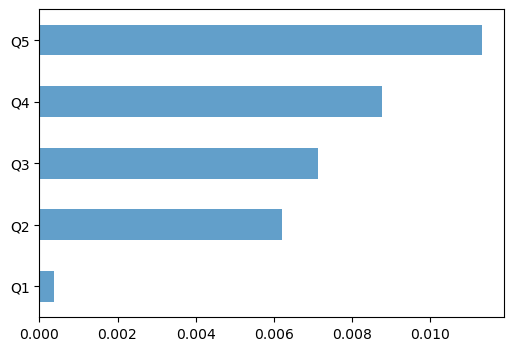

In [37]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1)

ret_12_portfolios.plot.barh(alpha=0.7)

### Q3.3

In Q3.2, you create the so-called equally weighted portfolios. In other words, the stocks in each group (Q1 -- Q5) have the same portfolio weights. However, the value-weighted portfolios are more common in reality. 

Suppose that we use $\text{ME}_{it}$ to denote the market capitalization of firm $i$ at time $t$. The value-weighted portfolio return in the group $j$ is <br>
<br>
$$
R^{vw}_{j,t+1} = \frac{\sum^{N_{jt}}_{i = 1} \text{ME}_{it} R_{i,t+1}}{\sum^{N_{jt}}_{i = 1} \text{ME}_{it}}, 
$$
where $N_{jt}$ is the number of firms in the $j$-th group at time $t$. 

In this question, you need to compute the value-weighted portfolio returns for the five groups of stocks sorted by the momentum signal. Finally, you need to make a bar plot of average returns in five groups, as in Q3.2. What are the differences in the five momentum portfolios between Q3.2 and Q3.3? 

In [38]:
ret_12_portfolios = pd.Series(np.zeros(5))

port_ret = ((D_subset3.loc[D_subset3['Q1']==1, 'ret_exc_lead1m'] 
             * D_subset3.loc[D_subset3['Q1']==1, 'me']).groupby(level=1).sum() / 
            D_subset3.loc[D_subset3['Q1']==1, 'me'].groupby(level=1).sum())
ret_12_portfolios.iloc[0] = port_ret.mean()

port_ret = ((D_subset3.loc[D_subset3['Q2']==1, 'ret_exc_lead1m'] 
             * D_subset3.loc[D_subset3['Q2']==1, 'me']).groupby(level=1).sum() / 
            D_subset3.loc[D_subset3['Q2']==1, 'me'].groupby(level=1).sum())
ret_12_portfolios.iloc[1] = port_ret.mean()

port_ret = ((D_subset3.loc[D_subset3['Q3']==1, 'ret_exc_lead1m'] 
             * D_subset3.loc[D_subset3['Q3']==1, 'me']).groupby(level=1).sum() / 
            D_subset3.loc[D_subset3['Q3']==1, 'me'].groupby(level=1).sum())
ret_12_portfolios.iloc[2] = port_ret.mean()

port_ret = ((D_subset3.loc[D_subset3['Q4']==1, 'ret_exc_lead1m'] 
             * D_subset3.loc[D_subset3['Q4']==1, 'me']).groupby(level=1).sum() / 
            D_subset3.loc[D_subset3['Q4']==1, 'me'].groupby(level=1).sum())
ret_12_portfolios.iloc[3] = port_ret.mean()

port_ret = ((D_subset3.loc[D_subset3['Q5']==1, 'ret_exc_lead1m'] 
             * D_subset3.loc[D_subset3['Q5']==1, 'me']).groupby(level=1).sum() / 
            D_subset3.loc[D_subset3['Q5']==1, 'me'].groupby(level=1).sum())
ret_12_portfolios.iloc[4] = port_ret.mean()

ret_12_portfolios.index = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']

In [39]:
ret_12_portfolios

Q1    0.003271
Q2    0.006340
Q3    0.006619
Q4    0.007586
Q5    0.009393
dtype: float64

---

<Axes: >

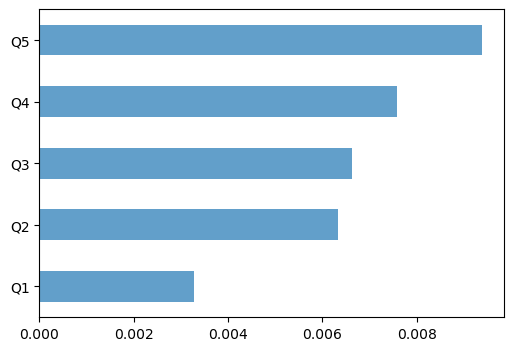

In [40]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1)

ret_12_portfolios.plot.barh(alpha=0.7)

# END